#Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [2]:
config = "multi_combined"

#Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/multi/KDDTrain_multi_combined.txt")
val_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/multi/KDDVal_multi_combined.txt")
test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nslkdd/multi/KDDTest_multi_combined.txt")

# séparation en x et y

x_train = train_set.drop(columns = ["class"])
x_val = val_set.drop(columns = ["class"])
x_test = test_set.drop(columns = ["class"])

y_train = train_set["class"]
y_val = val_set["class"]
y_test = test_set["class"]

#PCA
#initialisation PCA
#faut regler les parametres n_componenets

pca = PCA(n_components = 30)
pca = pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

print("# Of original features: ", x_train.shape[1])
print("# Features after reduction: ", x_train_pca.shape[1])
print("y_train shape", y_train.shape)
print("x_train shape", x_train.shape)

y_train.value_counts()

# Of original features:  117
# Features after reduction:  30
y_train shape (103597,)
x_train shape (103597, 117)


0    54049
1    37000
2     9821
3     2562
4      165
Name: class, dtype: int64

#Models and evaluation


#### Fonction d'evaluation

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, X_test, y_true):
    # Step 2: Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Step 3: Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Step 4: Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)

    # Step 5: Calculate F1-score
    f1score = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    # Step 6: Calculate Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1score)

    # Generate the classification report
    classes = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
    print("\n\n",classification_report(y_test, y_pred))

    # Step 6: Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)


    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4, 3))

    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

    # Set labels and title

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Set x-axis and y-axis tick labels
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    # Rotate the tick labels for better visibility
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Display the plot
    plt.show()

    num_classes = cm.shape[0]
    for class_idx in range(num_classes):
        row = cm[class_idx]

        tn = np.sum(np.delete(np.delete(cm, class_idx, axis=0), class_idx, axis=1))
        fp = np.sum(row) - cm[class_idx, class_idx]
        fn = np.sum(row) - cm[class_idx, class_idx]
        tp = cm[class_idx, class_idx]

        false_positive_rate = fp / (fp + tn)
        false_negative_rate = fn / (fn + tp)

        print("Class:", class_idx)
        print("False Positive Rate:", false_positive_rate)
        print("False Negative Rate:", false_negative_rate)
        print()

In [6]:
import matplotlib.pyplot as plt

def plot_metrics_comparison(history1, name1, history2, name2):
    # Extracting metrics from history objects
    accuracy1 = history1.history['accuracy']
    val_accuracy1 = history1.history['val_accuracy']
    loss1 = history1.history['loss']
    val_loss1 = history1.history['val_loss']

    accuracy2 = history2.history['accuracy']
    val_accuracy2 = history2.history['val_accuracy']
    loss2 = history2.history['loss']
    val_loss2 = history2.history['val_loss']

    # Creating subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting accuracy
    axs[0].plot(accuracy1, label=name1+' Training Accuracy')
    axs[0].plot(val_accuracy1, label=name1+' Validation Accuracy')
    axs[0].plot(accuracy2, label=name2 +' Training Accuracy')
    axs[0].plot(val_accuracy2, label=name2 +' Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Accuracy Comparison')
    axs[0].legend()

    # Plotting loss
    axs[1].plot(loss1, label=name1+' Training Loss')
    axs[1].plot(val_loss1, label=name1+' Validation Loss')
    axs[1].plot(loss2, label=name2 +' Training Loss')
    axs[1].plot(val_loss2, label=name2 +' Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss Comparison')
    axs[1].legend()

    # Adjusting spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()


In [7]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate classification metrics for the given true labels and predicted labels.
    Returns a dictionary of metric values.
    """
    metrics = {}
    y_pred =np.argmax(y_pred, axis=1)

    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    metrics['F1-score'] = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    return metrics

def write_metrics_to_dataframe(configuration_name, metrics_dict, df):
    """
    Write the classification metrics from the metrics dictionary to a DataFrame.
    The metrics are appended as a new row to the given DataFrame along with the configuration name.
    """
    metrics_dict['Configuration'] = configuration_name
    df = df.append(metrics_dict, ignore_index=True)
    return df

# Initializing the DataFrame
columns = ['Configuration', 'Accuracy', 'Recall', 'Precision', 'F1-score']
result_df = pd.DataFrame(columns=columns)


# Models


In [8]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM

## final model classification

### CNN

In [9]:
CNN = Sequential()
CNN.add(Conv1D(32, 3, activation='relu', input_shape=(x_train.shape[1],1)))
CNN.add(Conv1D(64, 3, activation='relu'))
CNN.add(MaxPooling1D(2))
CNN.add(Dropout(0.2))
CNN.add(Conv1D(128, 3, activation='relu'))
CNN.add(Conv1D(128, 3, activation='relu'))
CNN.add(MaxPooling1D(2))
CNN.add(Dropout(0.2))
CNN.add(Flatten())
CNN.add(Dense(256, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(5, activation='sigmoid'))
CNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNN.summary()

# Train the CNN
history = CNN.fit(x_train, y_train, epochs=80, validation_data=(x_val,y_val),batch_size = 64)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 115, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 113, 64)           6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 56, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 54, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 52, 128)           49280     
                                                        

696/696 [==============================] - 1s 2ms/step
Accuracy: 0.9924079065588499
Precision: 0.9924045130416872
Recall: 0.9924079065588499
F1-score: 0.9923755086256741


               precision    recall  f1-score   support

           0       0.99      0.99      0.99     11462
           1       1.00      1.00      1.00      8054
           2       0.99      0.99      0.99      2125
           3       0.91      0.91      0.91       570
           4       0.97      0.76      0.85        49

    accuracy                           0.99     22260
   macro avg       0.97      0.93      0.95     22260
weighted avg       0.99      0.99      0.99     22260



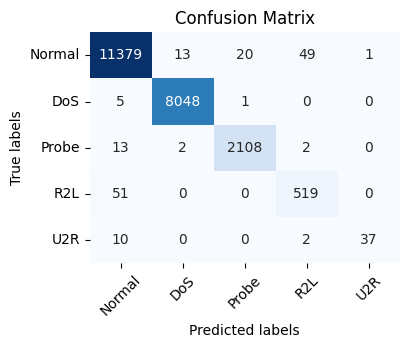

Class: 0
False Positive Rate: 0.007683762266246992
False Negative Rate: 0.00724131914151108

Class: 1
False Positive Rate: 0.00042262449813340846
False Negative Rate: 0.0007449714427613609

Class: 2
False Positive Rate: 0.0008444687298196811
False Negative Rate: 0.008

Class: 3
False Positive Rate: 0.002351530800442641
False Negative Rate: 0.08947368421052632

Class: 4
False Positive Rate: 0.0005400054000540005
False Negative Rate: 0.24489795918367346

696/696 [==============================] - 1s 2ms/step


<ipython-input-7-762dc581f4ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(metrics_dict, ignore_index=True)


In [10]:
evaluate_model(CNN, x_test, y_test)
result_df = write_metrics_to_dataframe("CNN "+ config, calculate_metrics(y_test, CNN.predict(x_test)), result_df)

### cnn lstm

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 117, 32)           64        
                                                                 
 conv1d_4 (Conv1D)           (None, 115, 128)          12416     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 57, 128)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 57, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 57, 128)           0         
                                                                 
 flatten_1 (Flatten)         (None, 7296)              0         
                                                      

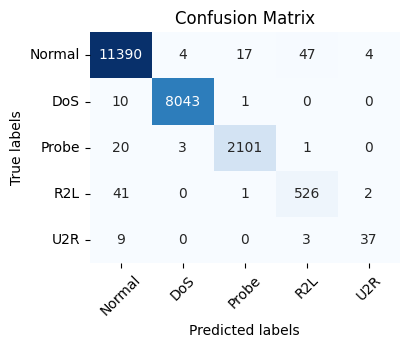

Class: 0
False Positive Rate: 0.006672845227062094
False Negative Rate: 0.006281626243238528

Class: 1
False Positive Rate: 0.0007741027445460943
False Negative Rate: 0.0013657809783958281

Class: 2
False Positive Rate: 0.0011916583912611719
False Negative Rate: 0.011294117647058824

Class: 3
False Positive Rate: 0.002029239496379652
False Negative Rate: 0.07719298245614035

Class: 4
False Positive Rate: 0.0005401269298285097
False Negative Rate: 0.24489795918367346

696/696 [==============================] - 2s 3ms/step


<ipython-input-7-762dc581f4ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(metrics_dict, ignore_index=True)


In [11]:
cnn_lstm = Sequential()
cnn_lstm.add(Dense(32, activation='relu', input_shape=(x_train.shape[1], 1)))
cnn_lstm.add(Conv1D(128, kernel_size=3, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(LSTM(128, return_sequences=True))
cnn_lstm.add(Dropout(0.3))
cnn_lstm.add(Flatten())
cnn_lstm.add(Dense(128, activation='relu'))
cnn_lstm.add(Dense(5, activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the cnn_lstm
cnn_lstm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_lstm.summary()
# Train the cnn_lstm
history2 = cnn_lstm.fit(x_train, y_train, epochs=80, validation_data=(x_val,y_val),batch_size = 64)
evaluate_model(cnn_lstm, x_test, y_test)
result_df = write_metrics_to_dataframe("cnn_lstm "+config, calculate_metrics(y_test, cnn_lstm.predict(x_test)), result_df)

696/696 [==============================] - 2s 3ms/step


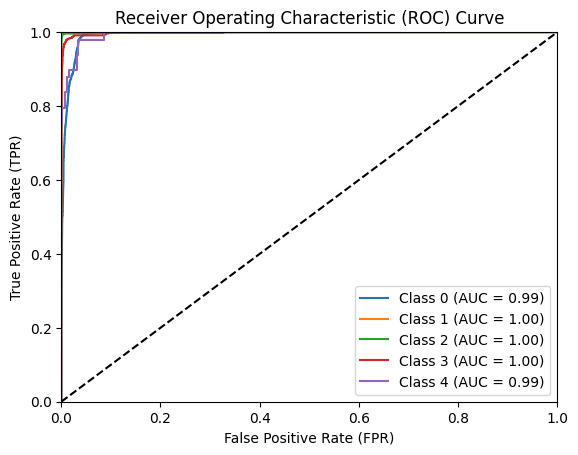

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming you have true labels (y_true) and predicted probabilities (y_pred_prob)
# y_true: true labels of the test data (multi-class labels)
# y_pred_prob: predicted probabilities of each class
y_pred_prob = cnn_lstm.predict(x_test)
# Binarize the true labels (one-hot encoding)
y_true_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 117, 32)           64        
                                                                 
 dense_6 (Dense)             (None, 117, 128)          4224      
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                

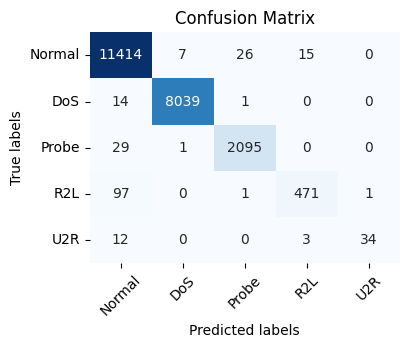

Class: 0
False Positive Rate: 0.0044884982233027865
False Negative Rate: 0.004187750828825685

Class: 1
False Positive Rate: 0.0010553718426792374
False Negative Rate: 0.001862428606903402

Class: 2
False Positive Rate: 0.0014897949049014253
False Negative Rate: 0.01411764705882353

Class: 3
False Positive Rate: 0.0045473336089293095
False Negative Rate: 0.1736842105263158

Class: 4
False Positive Rate: 0.0006749156355455568
False Negative Rate: 0.30612244897959184

696/696 [==============================] - 2s 3ms/step


<ipython-input-7-762dc581f4ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(metrics_dict, ignore_index=True)


In [13]:
lstm = Sequential()
lstm.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],1)))
lstm.add(Dense(128, activation ='relu'))
lstm.add(LSTM(128, return_sequences=False))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(Dense(5, activation='sigmoid'))

lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm.summary()

# Train the lstm
history3 = lstm.fit(x_train, y_train, epochs=80, validation_data=(x_val,y_val),batch_size = 64)

print("LSTM Classification report")
evaluate_model(lstm, x_test, y_test)
result_df = write_metrics_to_dataframe("lstm "+config, calculate_metrics(y_test, lstm.predict(x_test)), result_df)

### DNN

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 112)               13216     
                                                                 
 dense_11 (Dense)            (None, 64)                7232      
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 5)                 325       
                                                                 
Total params: 37,349
Trainable params: 37,349
Non-trai

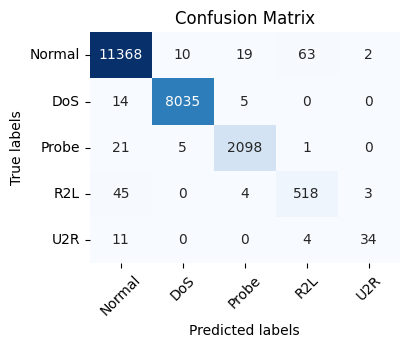

Class: 0
False Positive Rate: 0.008702897879825942
False Negative Rate: 0.008201012039783634

Class: 1
False Positive Rate: 0.0013370865587614357
False Negative Rate: 0.0023590762354109758

Class: 2
False Positive Rate: 0.0013410151981722458
False Negative Rate: 0.012705882352941176

Class: 3
False Positive Rate: 0.00239918796714958
False Negative Rate: 0.0912280701754386

Class: 4
False Positive Rate: 0.0006750371270419874
False Negative Rate: 0.30612244897959184

696/696 [==============================] - 1s 1ms/step


<ipython-input-7-762dc581f4ba>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(metrics_dict, ignore_index=True)


In [14]:
DNN = Sequential()
DNN.add(Dense(112, input_shape=(x_train.shape[1],), activation='relu'))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(128, activation='relu'))
DNN.add(Dropout(0.5))
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(5, activation='sigmoid'))

DNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
DNN.summary()

# Train the DNN
history4 = DNN.fit(x_train, y_train, epochs=80, validation_data=(x_val,y_val),batch_size = 64)

print("DNN Classification report")
evaluate_model(DNN, x_test, y_test)
result_df = write_metrics_to_dataframe("DNN "+config, calculate_metrics(y_test, DNN.predict(x_test)), result_df)

In [15]:
import matplotlib.pyplot as plt

def plot_metrics_comparison(histories, model_names):
    # Creating subplots for accuracy and loss
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plotting training and validation accuracy
    axs[0, 0].set_title('Training Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')

    axs[0, 1].set_title('Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')

    # Plotting training and validation loss
    axs[1, 0].set_title('Training Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')

    axs[1, 1].set_title('Validation Loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')

    # Plotting metrics for each model
    for i, history in enumerate(histories):
        model_name = model_names[i]
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Plotting training and validation accuracy
        axs[0, 0].plot(train_accuracy, label=model_name)
        axs[0, 1].plot(val_accuracy, label=model_name)

        # Plotting training and validation loss
        axs[1, 0].plot(train_loss, label=model_name)
        axs[1, 1].plot(val_loss, label=model_name)

    # Adjusting spacing between subplots
    plt.tight_layout()

    # Adding legends
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()

    # Display the plot
    plt.show()


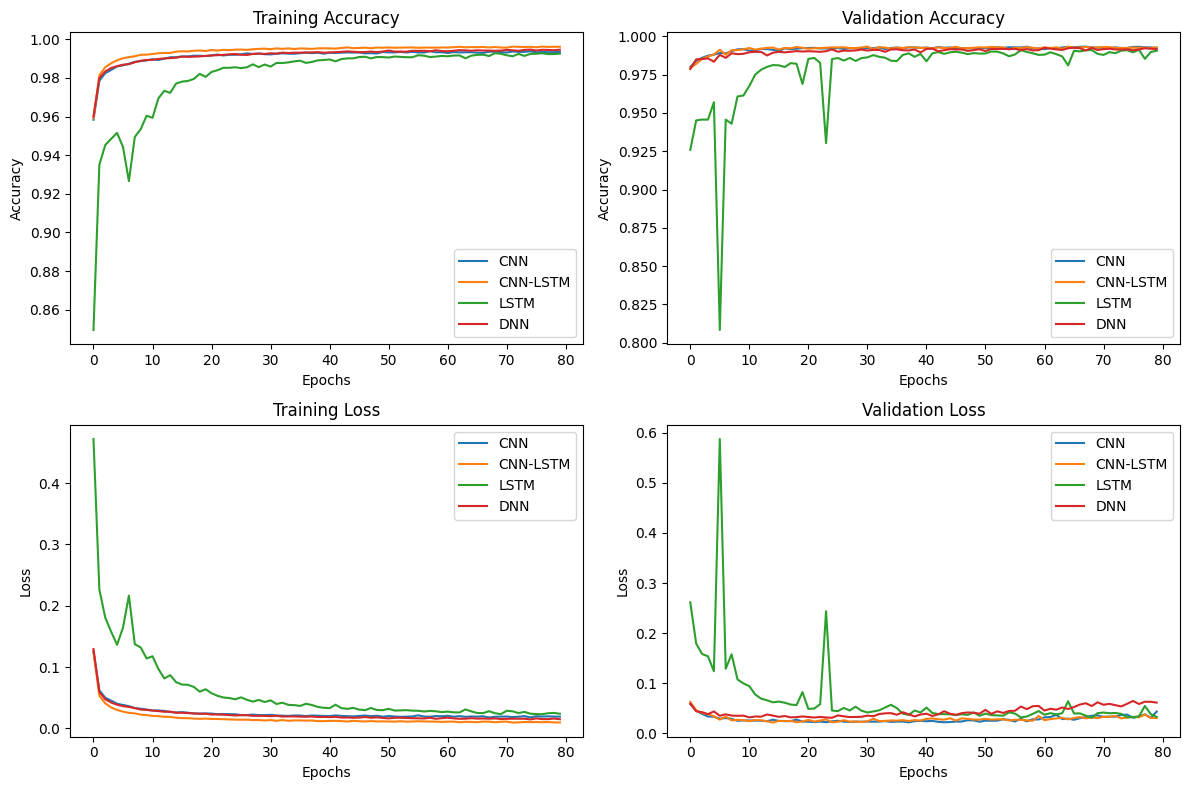

In [16]:
histories = [history,history2, history3, history4]
model_names = ['CNN', 'CNN-LSTM', 'LSTM', 'DNN']
plot_metrics_comparison(histories, model_names)

In [17]:
result_df.to_csv("/content/drive/MyDrive/Colab Notebooks/"+config+" multi .txt", index = False)